<a href="https://colab.research.google.com/github/george-sho-ivanov/US-Fascicle-Imaging/blob/main/OnnxSingleInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Basis of this Notebook is copied from and accredited to
https://github.com/njcronin/DL_Track/blob/master/COLAB_Inference_Single_Image.ipynb
as of 26/04/2024.

Additions for ONNX conversions and latency evaluation made by George Ivanov, KCL k21090575

In [2]:
%cd drive/My Drive/DL_Track
!pwd

/content/drive/My Drive/DL_Track
/content/drive/My Drive/DL_Track


In [ ]:
!pip install onnx
!pip install onnxruntime

In [4]:
import onnx
import onnxruntime
import time

from __future__ import division
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from skimage.transform import resize
from skimage.morphology import skeletonize
from scipy.signal import resample, savgol_filter, butter, filtfilt
from PIL import Image, ImageDraw
import cv2

from keras import backend as K
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [5]:
# Intersection over union (IoU), a measure of labelling accuracy (sometimes also called Jaccard score)
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

# Function to sort contours from proximal to distal (the bounding boxes are not used)
def sort_contours(cnts):
    # initialize the reverse flag and sort index
    i = 1
    # construct the list of bounding boxes and sort them from top to bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b:b[1][i], reverse=False))

    return (cnts, boundingBoxes)

# Find only the coordinates representing one edge of a contour. edge: T (top) or B (bottom)
def contour_edge(edge, contour):
    pts = list(contour)
    ptsT = sorted(pts, key=lambda k: [k[0][0], k[0][1]])
    allx = []
    ally = []
    for a in range(0,len(ptsT)):
        allx.append(ptsT[a][0,0])
        ally.append(ptsT[a][0,1])
    un = np.unique(allx)
    #sumA = 0
    leng = len(un)-1
    x = []
    y = []
    for each in range(5,leng-5): # Ignore 1st and last 5 points to avoid any curves
        indices = [i for i, x in enumerate(allx) if x == un[each]]
        if edge == 'T':
            loc = indices[0]
        else:
            loc = indices[-1]
        x.append(ptsT[loc][0,0])
        y.append(ptsT[loc][0,1])
    return np.array(x),np.array(y)

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

# Function to detect mouse clicks for the purpose of image calibration
def mclick(event, x, y, flags, param):
    # grab references to the global variables
    global mlocs

    # if the left mouse button was clicked, record the (x, y) coordinates
    if event == cv2.EVENT_LBUTTONDOWN:
        mlocs.append(y)

# Function to compute the distance between 2 x,y points
def distFunc(x1, y1, x2, y2):
    xdist = (x2 - x1)**2
    ydist = (y2 - y1)**2
    return np.sqrt(xdist + ydist)

###############################################################################

In [6]:
apo_threshold = 0.2                     # Sensitivity threshold for detecting aponeuroses
fasc_threshold = 0.10                   # Sensitivity threshold for detecting fascicles
fasc_cont_thresh = 40                   # Minimum accepted contour length for fascicles (px)
flip = 1                                # If fascicles are oriented bottom-left to top-right, leave as 0. Otherwise set to 1
min_width = 60                          # Minimum acceptable distance between aponeuroses
curvature = 1                           # Set to 3 for curved fascicles or 1 for a straight line
min_pennation = 14                      # Minimum and maximum acceptable pennation angles
max_pennation = 40

In [7]:
image_add = ('./WW112_100_G0/WW112_100_G0/11.png')

filename = './analysedImages/' + os.path.splitext(os.path.basename(image_add))[0]
img = load_img(image_add, color_mode='grayscale')
if flip == 1:
    img = np.fliplr(img)
img_copy = img
img = img_to_array(img)
h = img.shape[0]
w = img.shape[1]
img = np.reshape(img,[-1, h, w,1])
img = resize(img, (1, 512, 512, 1), mode = 'constant', preserve_range = True)
img = img/255.0
img2 = img
# calibDist = []

In [ ]:
### Run single image inference with profiling

#options = onnxruntime.SessionOptions()
#options.enable_profiling = True

ort_session_apo_profiled = onnxruntime.InferenceSession("./onnx_model/onnx_model.onnx", options)
ort_session_fasc_profiled = onnxruntime.InferenceSession("./onnx_model/onnx_model_fasc.onnx", options)

Run models with Profiling Enable, then saves profile to drive
pred_apo = ort_session_apo_profiled.run(None, {"img": img})
prof_file_apo = ort_session_apo_profiled.end_profiling()
pred_fasc = ort_session_fasc_profiled.run(None, {"img": img})
prof_file_fasc = ort_session_fasc_profiled.end_profiling()

pred_apo = pred_apo[0]
pred_fasc = pred_fasc[0]

pred_apo_t = (pred_apo > apo_threshold).astype(np.uint8) # SET APO THRESHOLD
pred_fasc_t = (pred_fasc > fasc_threshold).astype(np.uint8) # SET FASC THRESHOLD

img = resize(img, (1, h, w,1))
img = np.reshape(img, (h, w))
pred_apo = resize(pred_apo, (1, h, w,1))
pred_apo = np.reshape(pred_apo, (h, w))
pred_apo_t = resize(pred_apo_t, (1, h, w,1))
pred_apo_t = np.reshape(pred_apo_t, (h, w))

pred_fasc = resize(pred_fasc, (1, h, w,1))
pred_fasc = np.reshape(pred_fasc, (h, w))
pred_fasc_t = resize(pred_fasc_t, (1, h, w,1))
pred_fasc_t = np.reshape(pred_fasc_t, (h, w))

# # Uncomment these lines if you want to see the initial predictions
fig = plt.figure(figsize=(17,17))
ax1 = fig.add_subplot(131)
ax1.imshow(img.squeeze(),cmap='gray')
ax1.set_title('Original image')
ax2 = fig.add_subplot(132)
ax2.imshow(pred_apo_t.squeeze())
ax2.set_title('Aponeuroses')
ax3 = fig.add_subplot(133)
ax3.imshow(pred_fasc_t.squeeze())
ax3.set_title('Fascicles')

#########################################################################

xs = []
ys = []
fas_ext = []
fasc_l = []
pennation = []
x_low1 = []
x_high1 = []

# Compute contours to identify the aponeuroses
_, thresh = cv2.threshold(pred_apo_t, 0, 255, cv2.THRESH_BINARY)
thresh = thresh.astype('uint8')
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

contours_re = []
for contour in contours: # Remove any contours that are very small
    if len(contour) > 600:
        contours_re.append(contour)
contours = contours_re
contours,_ = sort_contours(contours) # Sort contours from top to bottom

# mask_apo = np.zeros(thresh.shape,np.uint8)
contours_re2 = []
for contour in contours:
#     cv2.drawContours(mask_apo,[contour],0,255,-1)
    pts = list(contour)
    ptsT = sorted(pts, key=lambda k: [k[0][0], k[0][1]]) # Sort each contour based on x values
    allx = []
    ally = []
    for a in range(0,len(ptsT)):
        allx.append(ptsT[a][0,0])
        ally.append(ptsT[a][0,1])
    app = np.array(list(zip(allx,ally)))
    contours_re2.append(app)

# Merge nearby contours
# countU = 0
xs1 = []
xs2 = []
ys1 = []
ys2 = []
maskT = np.zeros(thresh.shape,np.uint8)
for cnt in contours_re2:
    ys1.append(cnt[0][1])
    ys2.append(cnt[-1][1])
    xs1.append(cnt[0][0])
    xs2.append(cnt[-1][0])
    cv2.drawContours(maskT,[cnt],0,255,-1)

for countU in range(0,len(contours_re2)-1):
    if xs1[countU+1] > xs2[countU]: # Check if x of contour2 is higher than x of contour 1
        y1 = ys2[countU]
        y2 = ys1[countU+1]
        if y1-10 <= y2 <= y1+10:
            m = np.vstack((contours_re2[countU], contours_re2[countU+1]))
            cv2.drawContours(maskT,[m],0,255,-1)
    countU += 1

maskT[maskT > 0] = 1
skeleton = skeletonize(maskT).astype(np.uint8)
kernel = np.ones((3,7), np.uint8)
dilate = cv2.dilate(skeleton, kernel, iterations=15)
erode = cv2.erode(dilate, kernel, iterations=10)

contoursE, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask_apoE = np.zeros(thresh.shape,np.uint8)

contoursE = [i for i in contoursE if len(i) > 600] # Remove any contours that are very small

for contour in contoursE:
    cv2.drawContours(mask_apoE,[contour],0,255,-1)
contoursE,_ = sort_contours(contoursE)

# Only continues beyond this point if 2 aponeuroses can be detected
if len(contoursE) >= 2:
    # Get the x,y coordinates of the upper/lower edge of the 2 aponeuroses
    upp_x,upp_y = contour_edge('B', contoursE[0])
    if contoursE[1][0,0,1] > contoursE[0][0,0,1] + min_width:
        low_x,low_y = contour_edge('T', contoursE[1])
    else:
        low_x,low_y = contour_edge('T', contoursE[2])

    upp_y_new = savgol_filter(upp_y, 81, 2) # window size 51, polynomial order 3
    low_y_new = savgol_filter(low_y, 81, 2)

    # Make a binary mask to only include fascicles within the region between the 2 aponeuroses
    ex_mask = np.zeros(thresh.shape,np.uint8)
    ex_1 = 0
    ex_2 = np.minimum(len(low_x), len(upp_x))
    for ii in range(ex_1, ex_2):
        ymin = int(np.floor(upp_y_new[ii]))
        ymax = int(np.ceil(low_y_new[ii]))

        ex_mask[:ymin, ii] = 0
        ex_mask[ymax:, ii] = 0
        ex_mask[ymin:ymax, ii] = 255

    # Calculate slope of central portion of each aponeurosis & use this to compute muscle thickness
    Alist = list(set(upp_x).intersection(low_x))
    Alist = sorted(Alist)
    Alen = len(list(set(upp_x).intersection(low_x))) # How many values overlap between x-axes
    A1 = int(Alist[0] + (.33 * Alen))
    A2 = int(Alist[0] + (.66 * Alen))
    mid = int((A2-A1) / 2 + A1)
    mindist = 10000
    upp_ind = np.where(upp_x==mid)

    if upp_ind == len(upp_x):
            upp_ind -= 1

    for val in range(A1, A2):
        if val >= len(low_x):
            continue
        else:
            dist = distFunc(upp_x[upp_ind], upp_y_new[upp_ind], low_x[val], low_y_new[val])
            if dist < mindist:
                mindist = dist

    # Add aponeuroses to a mask for display
    # imgT = np.zeros((h,w,1), np.uint8)

    # Compute functions to approximate the shape of the aponeuroses
    zUA = np.polyfit(upp_x, upp_y_new, 2)
    g = np.poly1d(zUA)
    zLA = np.polyfit(low_x, low_y_new, 2)
    h = np.poly1d(zLA)

    mid = (low_x[-1]-low_x[0])/2 + low_x[0] # Find middle of the aponeurosis
    x1 = np.linspace(low_x[0]-700, low_x[-1]+700, 10000) # Extrapolate polynomial fits to either side of the mid-point
    y_UA = g(x1)
    y_LA = h(x1)

    new_X_UA = np.linspace(mid-700, mid+700, 5000) # Extrapolate x,y data using f function
    new_Y_UA = g(new_X_UA)
    new_X_LA = np.linspace(mid-700, mid+700, 5000) # Extrapolate x,y data using f function
    new_Y_LA = h(new_X_LA)

    #########################################################################

    # Compute contours to identify fascicles/fascicle orientation
    _, threshF = cv2.threshold(pred_fasc_t, 0, 255, cv2.THRESH_BINARY)
    threshF = threshF.astype('uint8')
    contoursF, hierarchy = cv2.findContours(threshF, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Remove any contours that are very small
#     contours_re = []
    maskF = np.zeros(threshF.shape,np.uint8)
    for contour in contoursF: # Remove any contours that are very small
        if len(contour) > fasc_cont_thresh:
#             contours_re.append(contour)
            cv2.drawContours(maskF,[contour],0,255,-1)

    # Only include fascicles within the region of the 2 aponeuroses
    mask_Fi = maskF & ex_mask
    contoursF2, hierarchy = cv2.findContours(mask_Fi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # maskF = np.zeros(threshF.shape,np.uint8)
#     contoursF3 = []
#     for contour in contoursF2:
#         if len(contour) > fasc_cont_thresh:
#     #         cv2.drawContours(maskF,[contour],0,255,-1)
#             contoursF3.append(contour)
    contoursF3 = [i for i in contoursF2 if len(i) > fasc_cont_thresh]

    fig = plt.figure(figsize=(25,25))

    xs = []
    ys = []
    fas_ext = []
    fasc_l = []
    pennation = []
    x_low1 = []
    x_high1 = []

    for contour in contoursF2:
        x,y = contour_edge('B', contour)
        if len(x) == 0:
            continue
        z = np.polyfit(np.array(x), np.array(y), 1)
        f = np.poly1d(z)
        newX = np.linspace(-400, w+400, 5000) # Extrapolate x,y data using f function
        newY = f(newX)

        # Find intersection between each fascicle and the aponeuroses.
        diffU = newY-new_Y_UA # Find intersections
        locU = np.where(diffU == min(diffU, key=abs))[0]
        diffL = newY-new_Y_LA
        locL = np.where(diffL == min(diffL, key=abs))[0]

        coordsX = newX[int(locL):int(locU)] # Get coordinates of fascicle between the two aponeuroses
        coordsY = newY[int(locL):int(locU)]

        # Get angle of aponeurosis in region close to fascicle intersection
        if locL >= 4950:
            Apoangle = int(np.arctan((new_Y_LA[locL-50]-new_Y_LA[locL-50])/(new_X_LA[locL]-new_X_LA[locL-50]))*180/np.pi)
        else:
            Apoangle = int(np.arctan((new_Y_LA[locL]-new_Y_LA[locL+50])/(new_X_LA[locL+50]-new_X_LA[locL]))*180/np.pi) # Angle relative to horizontal
        Apoangle = 90.0 + abs(Apoangle)

        # Don't include fascicles that are completely outside of the field of view or
        # those that don't pass through central 1/3 of the image
    #     if np.sum(coordsX) > 0 and coordsX[-1] > 0 and coordsX[0] < np.maximum(upp_x[-1],low_x[-1]) and coordsX[-1] - coordsX[0] < w and Apoangle != float('nan'):
        if np.sum(coordsX) > 0 and coordsX[-1] > 0 and coordsX[0] < np.maximum(upp_x[-1],low_x[-1]) and Apoangle != float('nan'):
            FascAng = float(np.arctan((coordsX[0]-coordsX[-1])/(new_Y_LA[locL]-new_Y_UA[locU]))*180/np.pi)*-1
            ActualAng = Apoangle-FascAng

            if ActualAng <= max_pennation and ActualAng >= min_pennation: # Don't include 'fascicles' beyond a range of pennation angles
                length1 = np.sqrt((newX[locU] - newX[locL])**2 + (y_UA[locU] - y_LA[locL])**2)
                fasc_l.append(length1[0]) # Calculate fascicle length
                pennation.append(Apoangle-FascAng)
                x_low1.append(coordsX[0].astype('int32'))
                x_high1.append(coordsX[-1].astype('int32'))
                coords = np.array(list(zip(coordsX.astype('int32'), coordsY.astype('int32'))))
                plt.plot(coordsX,coordsY,':w', linewidth = 6)
    # cv2.polylines(imgT, [coords], False, (20, 15, 200), 3)

    #########################################################################
    # DISPLAY THE RESULTS

    plt.imshow(img_copy, cmap='gray')
    plt.plot(low_x,low_y_new, marker='p', color='w', linewidth = 15) # Plot the aponeuroses
    plt.plot(upp_x,upp_y_new, marker='p', color='w', linewidth = 15)

    xplot = 125
    yplot = 250

    # Store the results for each frame and normalise using scale factor (if calibration was done above)
    try:
        midthick = mindist[0] # Muscle thickness
    except:
        midthick = mindist

    if 'calibDist' in locals():
        fasc_l = fasc_l / (calibDist/10)
        midthick = midthick / (calibDist/10)

        plt.text(xplot, yplot, ('Fascicle length: ' + str('%.2f' % np.median(fasc_l)) + ' mm'), fontsize=26, color='white')
        plt.text(xplot, yplot+50, ('Pennation angle: ' + str('%.1f' % np.median(pennation)) + ' deg'), fontsize=26, color='white')
        plt.text(xplot, yplot+100, ('Thickness at centre: ' + str('%.1f' % midthick) + ' mm'), fontsize=26, color='white')
        plt.grid(False)

    else:
        plt.text(xplot, yplot, ('Fascicle length: ' + str('%.1f' % np.median(fasc_l)) + ' px'), fontsize=26, color='white')
        plt.text(xplot, yplot+50, ('Pennation angle: ' + str('%.1f' % np.median(pennation)) + ' deg'), fontsize=26, color='white')
        plt.text(xplot, yplot+100, ('Thickness at centre: ' + str('%.1f' % midthick) + ' px'), fontsize=26, color='white')
        plt.grid(False)

else:
    print('***************************************************')
    print("Couldn't detect two aponeuroses!")
    print("Try reducing 'apo_threshold' in the settings above")
    print('***************************************************')


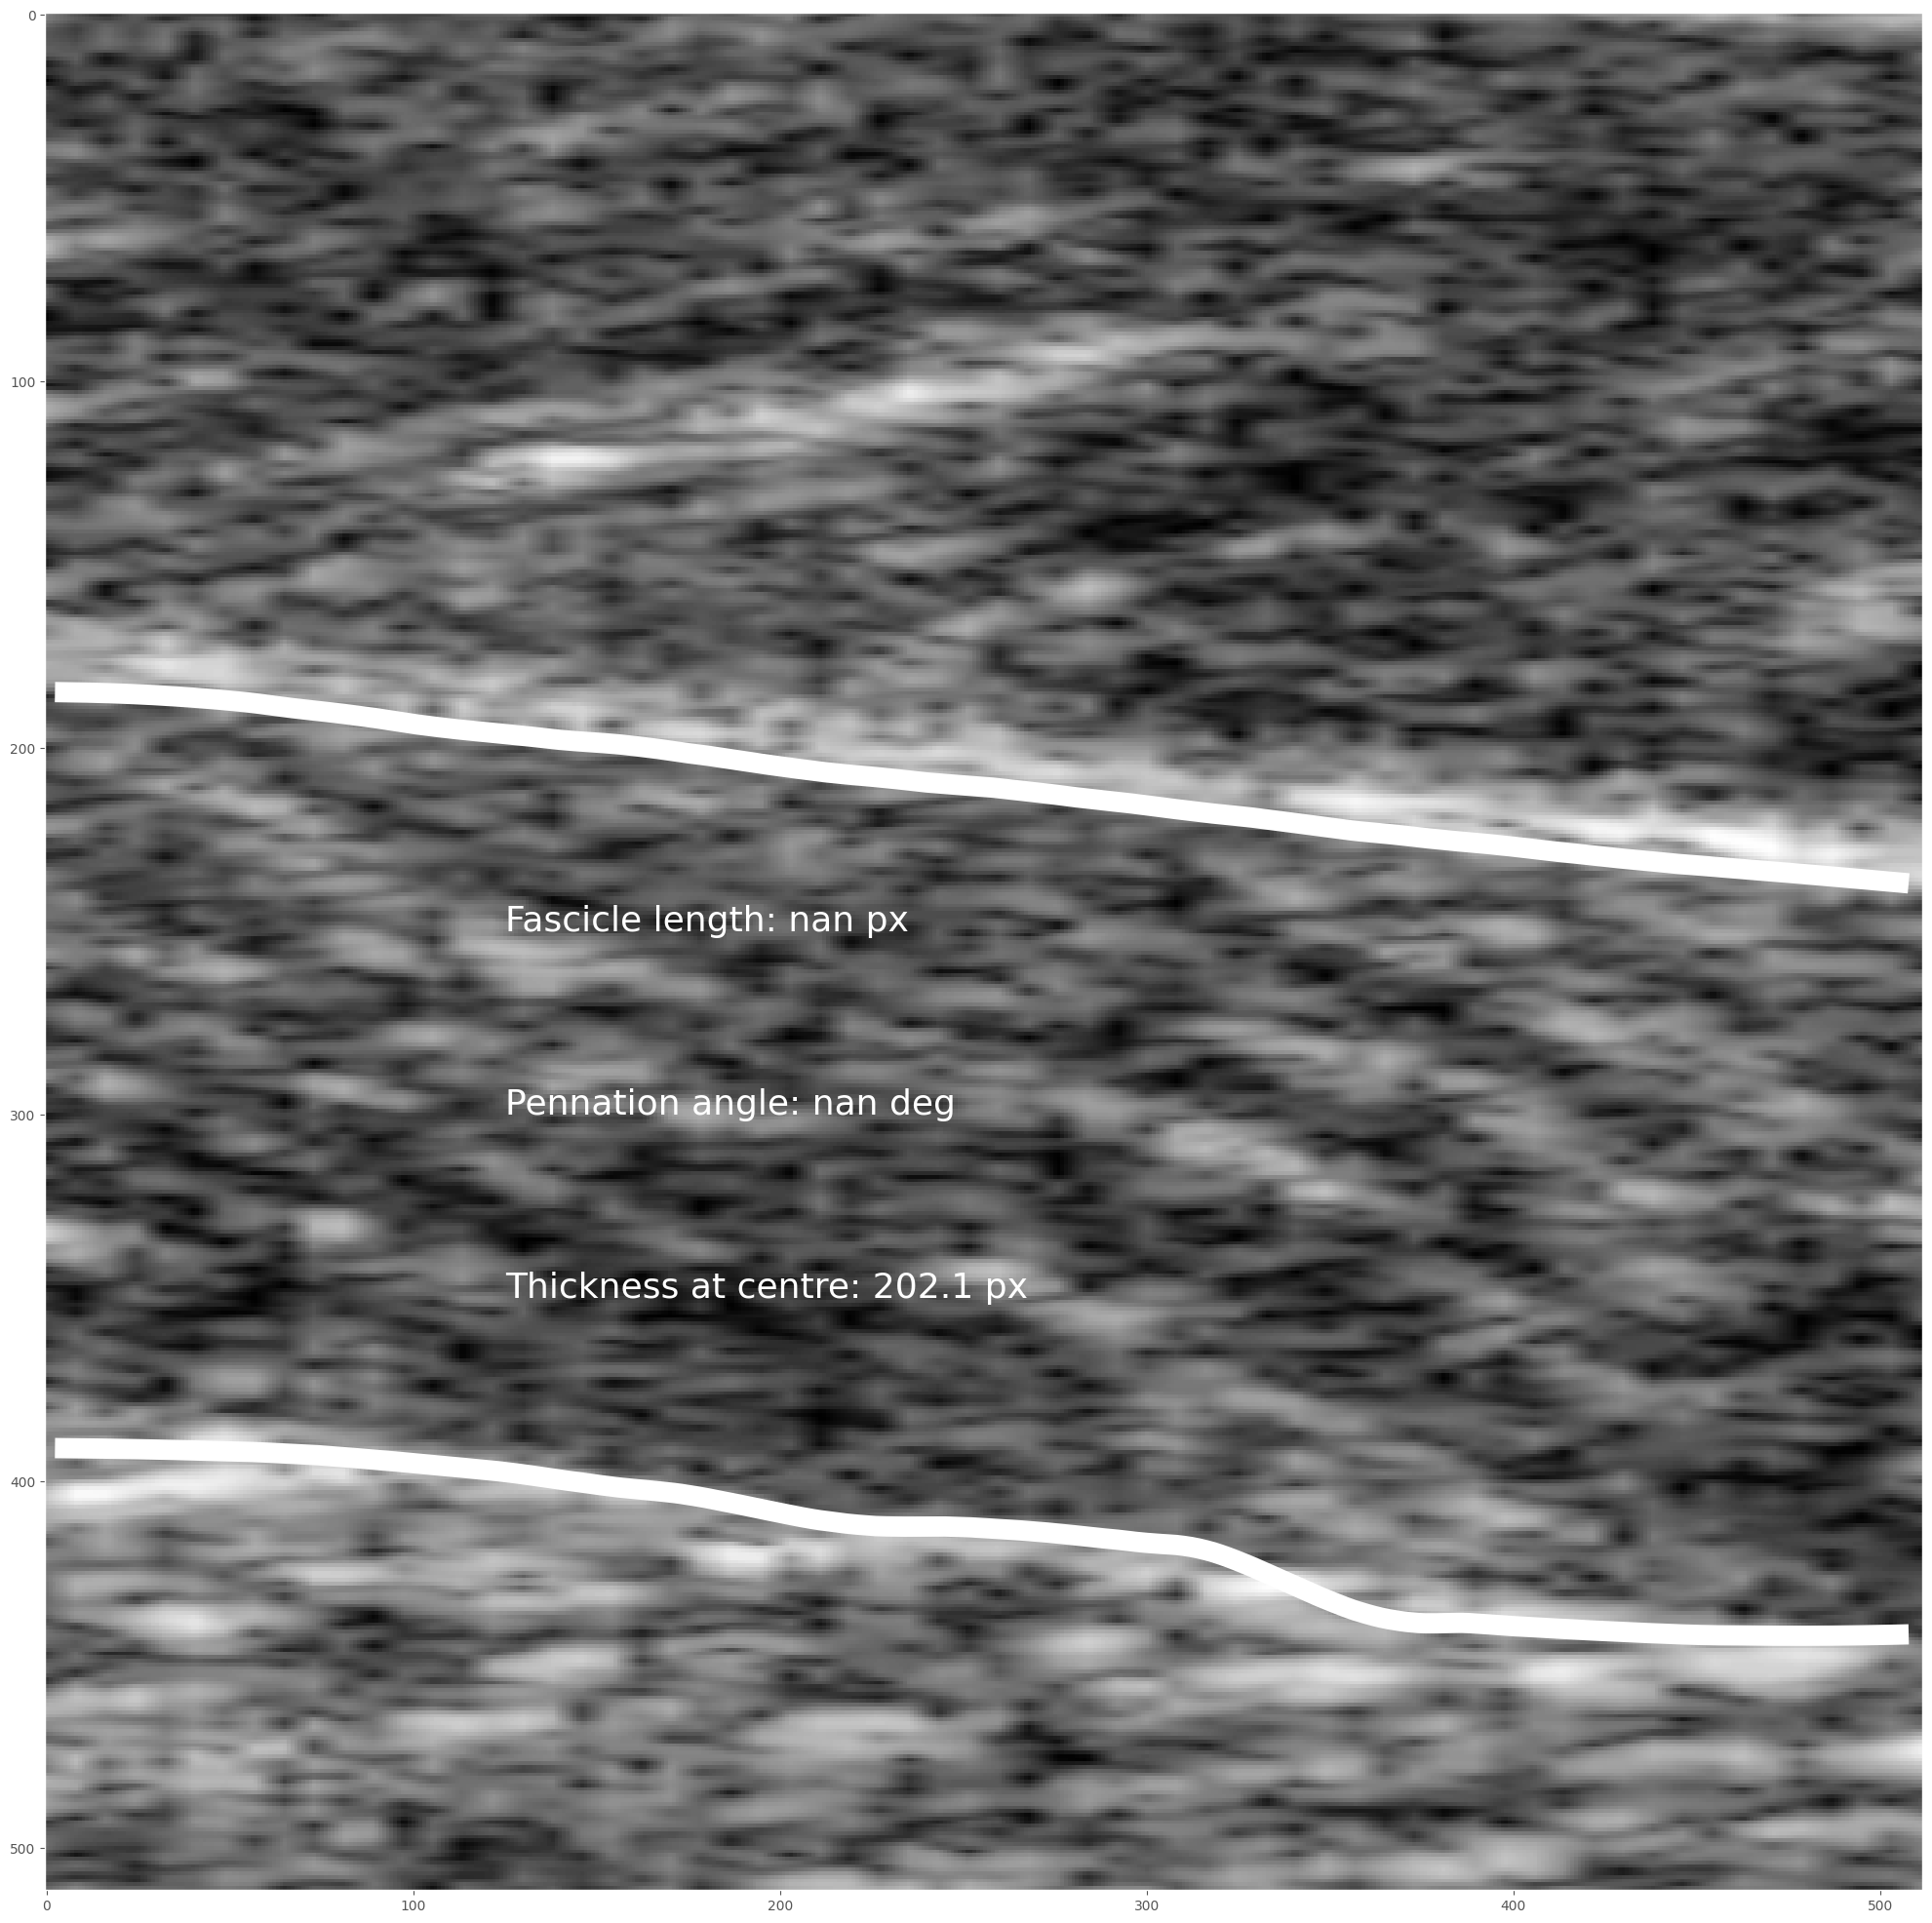

Elapsed Time for both models over folder: 263.0537796020508 seconds


In [ ]:
### Run Inference on a directory of B-mode US images

import os
import cv2
import numpy as np
from IPython.display import clear_output
from time import sleep

# Directory containing images
images_dir = './WW112_100_G0/WW112_100_G0'

# Start timing
start_time = time.time()

### Inference with standard ONNX coverted model
ort_session_apo = onnxruntime.InferenceSession("./onnx_model/onnx_model.onnx")
ort_session_fasc = onnxruntime.InferenceSession("./onnx_model/onnx_model_fasc.onnx")

### Inference with extended optimiziation ONNX models using ORT
# apo_options = onnxruntime.SessionOptions()
# apo_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
# fasc_options = onnxruntime.SessionOptions()
# fasc_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
#ort_session_apo = onnxruntime.InferenceSession("./onnx_model/onnx_model.onnx", apo_options)
#ort_session_fasc = onnxruntime.InferenceSession("./onnx_model/onnx_model_fasc.onnx", fasc_options)

### Inference with quantized ONNX model
#ort_session_apo = onnxruntime.InferenceSession("./onnx_model/apo_model.quant.onnx")
#ort_session_fasc = onnxruntime.InferenceSession("./onnx_model/fasc_model.quant.onnx")

# Iterate through images in directory
count = 0
predictions = []
for filename in os.listdir(images_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load and preprocess image
        image_add = os.path.join(images_dir, filename)
        # Perform preprocessing on 'image' to match model input requirements

        #filename = './analysedImages/' + os.path.splitext(os.path.basename(image_add))[0]
        img = load_img(image_add, color_mode='grayscale')
        if flip == 1:
            img = np.fliplr(img)
        img_copy = img
        img = img_to_array(img)
        h = img.shape[0]
        w = img.shape[1]
        img = np.reshape(img,[-1, h, w,1])
        img = resize(img, (1, 512, 512, 1), mode = 'constant', preserve_range = True)
        img = img/255.0
        img2 = img
        # calibDist = []

        # Predict
        # For example, if you're using a CNN model:
        # prediction = model.predict(image)

        pred_apo = ort_session_apo.run(None, {"img": img})
        pred_fasc = ort_session_fasc.run(None, {"img": img})
        count += 1
        print("Inference run on: ", count ," images")


        ####  Uncomment below to view inferred contour masks overlaid on US Image

        pred_apo = pred_apo[0]
        pred_fasc = pred_fasc[0]

        #pred_apo = model_apo.predict(img)
        pred_apo_t = (pred_apo > apo_threshold).astype(np.uint8) # SET APO THRESHOLD

        #pred_fasc = modelF.predict(img)
        pred_fasc_t = (pred_fasc > fasc_threshold).astype(np.uint8) # SET FASC THRESHOLD

        img = resize(img, (1, h, w,1))
        img = np.reshape(img, (h, w))
        pred_apo = resize(pred_apo, (1, h, w,1))
        pred_apo = np.reshape(pred_apo, (h, w))
        pred_apo_t = resize(pred_apo_t, (1, h, w,1))
        pred_apo_t = np.reshape(pred_apo_t, (h, w))

        pred_fasc = resize(pred_fasc, (1, h, w,1))
        pred_fasc = np.reshape(pred_fasc, (h, w))
        pred_fasc_t = resize(pred_fasc_t, (1, h, w,1))
        pred_fasc_t = np.reshape(pred_fasc_t, (h, w))

        # # Uncomment these lines if you want to see the initial predictions
        # fig = plt.figure(figsize=(17,17))
        # ax1 = fig.add_subplot(131)
        # ax1.imshow(img.squeeze(),cmap='gray')
        # ax1.set_title('Original image')
        # ax2 = fig.add_subplot(132)
        # ax2.imshow(pred_apo_t.squeeze())
        # ax2.set_title('Aponeuroses')
        # ax3 = fig.add_subplot(133)
        # ax3.imshow(pred_fasc_t.squeeze())
        # ax3.set_title('Fascicles')

        #########################################################################

        xs = []
        ys = []
        fas_ext = []
        fasc_l = []
        pennation = []
        x_low1 = []
        x_high1 = []

        # Compute contours to identify the aponeuroses
        _, thresh = cv2.threshold(pred_apo_t, 0, 255, cv2.THRESH_BINARY)
        thresh = thresh.astype('uint8')
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        contours_re = []
        for contour in contours: # Remove any contours that are very small
            if len(contour) > 600:
                contours_re.append(contour)
        contours = contours_re
        contours,_ = sort_contours(contours) # Sort contours from top to bottom

        # mask_apo = np.zeros(thresh.shape,np.uint8)
        contours_re2 = []
        for contour in contours:
        #     cv2.drawContours(mask_apo,[contour],0,255,-1)
            pts = list(contour)
            ptsT = sorted(pts, key=lambda k: [k[0][0], k[0][1]]) # Sort each contour based on x values
            allx = []
            ally = []
            for a in range(0,len(ptsT)):
                allx.append(ptsT[a][0,0])
                ally.append(ptsT[a][0,1])
            app = np.array(list(zip(allx,ally)))
            contours_re2.append(app)

        # Merge nearby contours
        # countU = 0
        xs1 = []
        xs2 = []
        ys1 = []
        ys2 = []
        maskT = np.zeros(thresh.shape,np.uint8)
        for cnt in contours_re2:
            ys1.append(cnt[0][1])
            ys2.append(cnt[-1][1])
            xs1.append(cnt[0][0])
            xs2.append(cnt[-1][0])
            cv2.drawContours(maskT,[cnt],0,255,-1)

        for countU in range(0,len(contours_re2)-1):
            if xs1[countU+1] > xs2[countU]: # Check if x of contour2 is higher than x of contour 1
                y1 = ys2[countU]
                y2 = ys1[countU+1]
                if y1-10 <= y2 <= y1+10:
                    m = np.vstack((contours_re2[countU], contours_re2[countU+1]))
                    cv2.drawContours(maskT,[m],0,255,-1)
            countU += 1

        maskT[maskT > 0] = 1
        skeleton = skeletonize(maskT).astype(np.uint8)
        kernel = np.ones((3,7), np.uint8)
        dilate = cv2.dilate(skeleton, kernel, iterations=15)
        erode = cv2.erode(dilate, kernel, iterations=10)

        contoursE, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        mask_apoE = np.zeros(thresh.shape,np.uint8)

        contoursE = [i for i in contoursE if len(i) > 600] # Remove any contours that are very small

        for contour in contoursE:
            cv2.drawContours(mask_apoE,[contour],0,255,-1)
        contoursE,_ = sort_contours(contoursE)

        # Only continues beyond this point if 2 aponeuroses can be detected
        if len(contoursE) >= 2:
            # Get the x,y coordinates of the upper/lower edge of the 2 aponeuroses
            upp_x,upp_y = contour_edge('B', contoursE[0])
            if contoursE[1][0,0,1] > contoursE[0][0,0,1] + min_width:
                low_x,low_y = contour_edge('T', contoursE[1])
            else:
                low_x,low_y = contour_edge('T', contoursE[2])

            upp_y_new = savgol_filter(upp_y, 81, 2) # window size 51, polynomial order 3
            low_y_new = savgol_filter(low_y, 81, 2)

            # Make a binary mask to only include fascicles within the region between the 2 aponeuroses
            ex_mask = np.zeros(thresh.shape,np.uint8)
            ex_1 = 0
            ex_2 = np.minimum(len(low_x), len(upp_x))
            for ii in range(ex_1, ex_2):
                ymin = int(np.floor(upp_y_new[ii]))
                ymax = int(np.ceil(low_y_new[ii]))

                ex_mask[:ymin, ii] = 0
                ex_mask[ymax:, ii] = 0
                ex_mask[ymin:ymax, ii] = 255

            # Calculate slope of central portion of each aponeurosis & use this to compute muscle thickness
            Alist = list(set(upp_x).intersection(low_x))
            Alist = sorted(Alist)
            Alen = len(list(set(upp_x).intersection(low_x))) # How many values overlap between x-axes
            A1 = int(Alist[0] + (.33 * Alen))
            A2 = int(Alist[0] + (.66 * Alen))
            mid = int((A2-A1) / 2 + A1)
            mindist = 10000
            upp_ind = np.where(upp_x==mid)

            if upp_ind == len(upp_x):
                    upp_ind -= 1

            for val in range(A1, A2):
                if val >= len(low_x):
                    continue
                else:
                    dist = distFunc(upp_x[upp_ind], upp_y_new[upp_ind], low_x[val], low_y_new[val])
                    if dist < mindist:
                        mindist = dist

            # Add aponeuroses to a mask for display
            # imgT = np.zeros((h,w,1), np.uint8)

            # Compute functions to approximate the shape of the aponeuroses
            zUA = np.polyfit(upp_x, upp_y_new, 2)
            g = np.poly1d(zUA)
            zLA = np.polyfit(low_x, low_y_new, 2)
            h = np.poly1d(zLA)

            mid = (low_x[-1]-low_x[0])/2 + low_x[0] # Find middle of the aponeurosis
            x1 = np.linspace(low_x[0]-700, low_x[-1]+700, 10000) # Extrapolate polynomial fits to either side of the mid-point
            y_UA = g(x1)
            y_LA = h(x1)

            new_X_UA = np.linspace(mid-700, mid+700, 5000) # Extrapolate x,y data using f function
            new_Y_UA = g(new_X_UA)
            new_X_LA = np.linspace(mid-700, mid+700, 5000) # Extrapolate x,y data using f function
            new_Y_LA = h(new_X_LA)

            #########################################################################

            # Compute contours to identify fascicles/fascicle orientation
            _, threshF = cv2.threshold(pred_fasc_t, 0, 255, cv2.THRESH_BINARY)
            threshF = threshF.astype('uint8')
            contoursF, hierarchy = cv2.findContours(threshF, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Remove any contours that are very small
        #     contours_re = []
            maskF = np.zeros(threshF.shape,np.uint8)
            for contour in contoursF: # Remove any contours that are very small
                if len(contour) > fasc_cont_thresh:
        #             contours_re.append(contour)
                    cv2.drawContours(maskF,[contour],0,255,-1)

            # Only include fascicles within the region of the 2 aponeuroses
            mask_Fi = maskF & ex_mask
            contoursF2, hierarchy = cv2.findContours(mask_Fi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            # maskF = np.zeros(threshF.shape,np.uint8)
        #     contoursF3 = []
        #     for contour in contoursF2:
        #         if len(contour) > fasc_cont_thresh:
        #     #         cv2.drawContours(maskF,[contour],0,255,-1)
        #             contoursF3.append(contour)
            contoursF3 = [i for i in contoursF2 if len(i) > fasc_cont_thresh]

            fig = plt.figure(figsize=(25,25))

            xs = []
            ys = []
            fas_ext = []
            fasc_l = []
            pennation = []
            x_low1 = []
            x_high1 = []

            for contour in contoursF2:
                x,y = contour_edge('B', contour)
                if len(x) == 0:
                    continue
                z = np.polyfit(np.array(x), np.array(y), 1)
                f = np.poly1d(z)
                newX = np.linspace(-400, w+400, 5000) # Extrapolate x,y data using f function
                newY = f(newX)

                # Find intersection between each fascicle and the aponeuroses.
                diffU = newY-new_Y_UA # Find intersections
                locU = np.where(diffU == min(diffU, key=abs))[0]
                diffL = newY-new_Y_LA
                locL = np.where(diffL == min(diffL, key=abs))[0]

                coordsX = newX[int(locL):int(locU)] # Get coordinates of fascicle between the two aponeuroses
                coordsY = newY[int(locL):int(locU)]

                # Get angle of aponeurosis in region close to fascicle intersection
                if locL >= 4950:
                    Apoangle = int(np.arctan((new_Y_LA[locL-50]-new_Y_LA[locL-50])/(new_X_LA[locL]-new_X_LA[locL-50]))*180/np.pi)
                else:
                    Apoangle = int(np.arctan((new_Y_LA[locL]-new_Y_LA[locL+50])/(new_X_LA[locL+50]-new_X_LA[locL]))*180/np.pi) # Angle relative to horizontal
                Apoangle = 90.0 + abs(Apoangle)

                # Don't include fascicles that are completely outside of the field of view or
                # those that don't pass through central 1/3 of the image
            #     if np.sum(coordsX) > 0 and coordsX[-1] > 0 and coordsX[0] < np.maximum(upp_x[-1],low_x[-1]) and coordsX[-1] - coordsX[0] < w and Apoangle != float('nan'):
                if np.sum(coordsX) > 0 and coordsX[-1] > 0 and coordsX[0] < np.maximum(upp_x[-1],low_x[-1]) and Apoangle != float('nan'):
                    FascAng = float(np.arctan((coordsX[0]-coordsX[-1])/(new_Y_LA[locL]-new_Y_UA[locU]))*180/np.pi)*-1
                    ActualAng = Apoangle-FascAng

                    if ActualAng <= max_pennation and ActualAng >= min_pennation: # Don't include 'fascicles' beyond a range of pennation angles
                        length1 = np.sqrt((newX[locU] - newX[locL])**2 + (y_UA[locU] - y_LA[locL])**2)
                        fasc_l.append(length1[0]) # Calculate fascicle length
                        pennation.append(Apoangle-FascAng)
                        x_low1.append(coordsX[0].astype('int32'))
                        x_high1.append(coordsX[-1].astype('int32'))
                        coords = np.array(list(zip(coordsX.astype('int32'), coordsY.astype('int32'))))
                        plt.plot(coordsX,coordsY,':w', linewidth = 6)
            # cv2.polylines(imgT, [coords], False, (20, 15, 200), 3)

            #########################################################################
            # DISPLAY THE RESULTS

            clear_output()
            plt.imshow(img_copy, cmap='gray')
            plt.plot(low_x,low_y_new, marker='p', color='w', linewidth = 15) # Plot the aponeuroses
            plt.plot(upp_x,upp_y_new, marker='p', color='w', linewidth = 15)

            xplot = 125
            yplot = 250

            # Store the results for each frame and normalise using scale factor (if calibration was done above)
            try:
                midthick = mindist[0] # Muscle thickness
            except:
                midthick = mindist

            if 'calibDist' in locals():
                fasc_l = fasc_l / (calibDist/10)
                midthick = midthick / (calibDist/10)

                plt.text(xplot, yplot, ('Fascicle length: ' + str('%.2f' % np.median(fasc_l)) + ' mm'), fontsize=26, color='white')
                plt.text(xplot, yplot+50, ('Pennation angle: ' + str('%.1f' % np.median(pennation)) + ' deg'), fontsize=26, color='white')
                plt.text(xplot, yplot+100, ('Thickness at centre: ' + str('%.1f' % midthick) + ' mm'), fontsize=26, color='white')
                plt.grid(False)

            else:
                plt.text(xplot, yplot, ('Fascicle length: ' + str('%.1f' % np.median(fasc_l)) + ' px'), fontsize=26, color='white')
                plt.text(xplot, yplot+50, ('Pennation angle: ' + str('%.1f' % np.median(pennation)) + ' deg'), fontsize=26, color='white')
                plt.text(xplot, yplot+100, ('Thickness at centre: ' + str('%.1f' % midthick) + ' px'), fontsize=26, color='white')
                plt.grid(False)

            plt.show()

        else:
            print('***************************************************')
            print("Couldn't detect two aponeuroses!")
            print("Try reducing 'apo_threshold' in the settings above")
            print('***************************************************')

#End timing
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time for both models over folder:", elapsed_time, "seconds")

In [ ]:
### Quantize ONNX model into unsigned 8-bit Int. Save models in quant.onnx

from onnxruntime.quantization import quantize_dynamic, QuantType

model_fp32 = './onnx_model/onnx_model.onnx'
model_quant = './onnx_model/apo_model.quant.onnx'
quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
model_fp32 = './onnx_model/onnx_model_fasc.onnx'
model_quant = './onnx_model/fasc_model.quant.onnx'
quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)